In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
from baa import PerplexityBenchmark, get_memory_usage
from datasets import load_dataset

In [2]:
# model_name = "HuggingFaceTB/SmolLM-135M-Instruct"
model_name = "meta-llama/Llama-3.2-3B-Instruct"
# model_name = "meta-llama/Llama-3.1-8B-Instruct"

In [3]:
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm

In [5]:
component_memory_usage = {
    "Full Model": get_memory_usage(model.model) / 1024**2,
    "MLP": get_memory_usage(model.model.layers[0].mlp)
    / 1024**2
    * len(model.model.layers),
    "Self Attention": get_memory_usage(model.model.layers[0].self_attn)
    / 1024**2
    * len(model.model.layers),
    "Model Head": get_memory_usage(model.lm_head) / 1024**2,
    # "Decoder Blocks": get_memory_usage(model.model.layers[:]) / 1024**2,
}

for component, usage in component_memory_usage.items():
    print(f"{component}: {usage:.2f} MB")

Full Model: 12255.67 MB
MLP: 8064.00 MB
Self Attention: 2688.00 MB
Model Head: 1503.00 MB


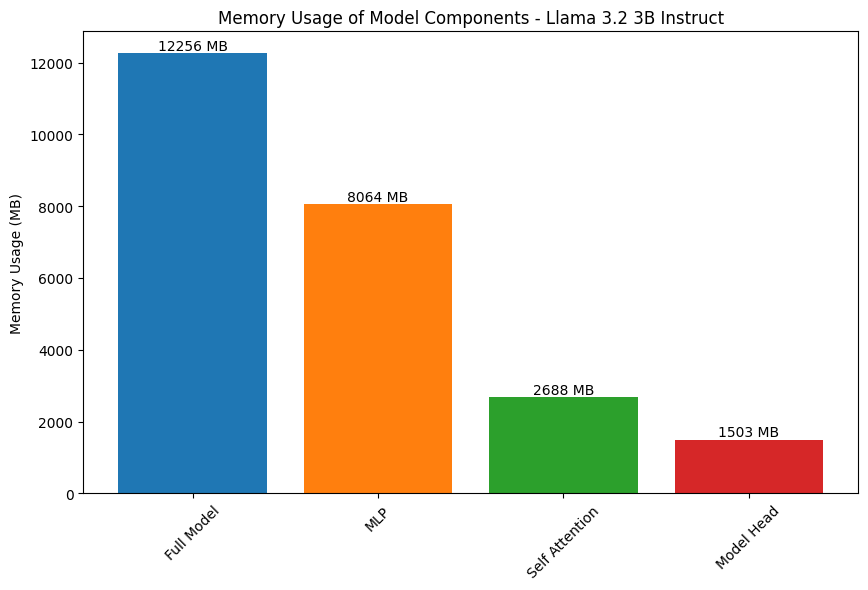

In [26]:
import matplotlib
import matplotlib.pyplot as plt

labels = []
memory_usage = []

for component, usage in component_memory_usage.items():
    labels.append(component)
    memory_usage.append(usage)

# assert that embedding + attention heads + model head ~= full model
assert sum(memory_usage[1:4]) - memory_usage[0] < 30 * 1024**2

# Generate colors for each category (index-based)
cmap = matplotlib.colormaps["tab10"]
colors = [cmap(i) for i in range(len(component_memory_usage))]
plt.figure(figsize=(10, 6))
plt.bar(labels, memory_usage, color=colors)
# show numbers on top of bars
for i, usage in enumerate(memory_usage):
    plt.text(i, usage, f"{usage:.0f} MB", ha="center", va="bottom")
plt.ylabel("Memory Usage (MB)")
plt.title("Memory Usage of Model Components - Llama 3.2 3B Instruct")
plt.xticks(rotation=45)

# save to visualizations folder
plt.savefig("visualizations/memory_usage-llama3.2-3b-instruct.png")

plt.show()